# About Jupyter Notebook
For some of you, this might be your first time using a Jupyter notebook. Here are a few tips to get you started!

A Jupyter notebook is a file with the .ipynb extension, just like this one. It's made up of *cells*, which can be:
- Code cells - where you write your code
- Markdown cells - where you write formatted text (like this section!)

Code cell are labeled with `[ ]` on the left. When a cell is running, the label changes to `[*]`. The number inside the brackets shows the order in which cells have been executed by the *kernel*.

So, what is the kernel? The kernel is the coputational 'engine' that runs the code. This notebook is connected to a Python kernel.

### Useful Keyboard Shortcuts
Jupyter notebooks offer helpful keyboard shortcuts that may save your time. First, make sure you are in *command mode* (not editing a cell). Press <kbd>Esc</kbd> or click outside the cell to exit *edit mode*.

Here are some handy shortcuts:
- Insert a new cell above or below → press <kbd>A</kbd> or <kbd>B</kbd>
- Delete a cell → press <kbd>D</kbd> twice (Note: Deleted cells cannot be recovered!)
- Restart the kernel and run all cells → press <kbd>0</kbd> twice (this is a zero!)
- Run the selected cell → press <kbd>Ctrl</kbd> + <kbd>Enter</kbd>
- Run the selected cell and move to the next cell → press <kbd>Shift</kbd> + <kbd>Enter</kbd>

Please check out the toolbar and menu bar at the top of the notebook for more options.

# The Experiment
This experiment uses custom modules in the *backend* folder, which have been specifically developed for this third-year lab.

Please run the cell below to install the required packages. You will need to do this **each time you start the server**.

In [1]:
!pip install atlasopenmagic
!pip install pyarrow==20.0.0 awkward==2.8.5

  Using cached atlasopenmagic-1.2.0-py3-none-any.whl.metadata (8.6 kB)
Using cached atlasopenmagic-1.2.0-py3-none-any.whl (16 kB)
  Using cached pyarrow-20.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached awkward-2.8.5-py3-none-any.whl.metadata (6.9 kB)
  Using cached awkward_cpp-47-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached pyarrow-20.0.0-cp312-cp312-manylinux_2_28_x86_64.whl (42.3 MB)
Using cached awkward-2.8.5-py3-none-any.whl (886 kB)
Using cached awkward_cpp-47-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (639 kB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.0
    Uninstalling pyarrow-19.0.0:
      Successfully uninstalled pyarrow-19.0.0━━━ 0/3 [pyarrow]
  Attempting uninstall: awkward-cpp━━━━━━━━━━━━━ 0/3 [pyarrow]
    Found existing installation: awkward_cpp 45m 0/3 [pyarrow]
    Uninstalling awkward_cpp-45:━━━━━━━━━━━━ 0/3 [pyarrow]
      Successfully uninst

Next, run the cell below to import the required modules and functions for the experiment. Repeat this step **every time you restart the kernel**.

In [3]:
import os
import re
import awkward as ak
import time
import datetime
from zoneinfo import ZoneInfo
import uproot
import glob
import numpy as np
import vector
import hist
from hist import Hist
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator # for minor ticks
from collections import defaultdict
from lmfit.models import PolynomialModel, GaussianModel
import pyarrow.parquet as pq

from backend import get_valid_variables, validate_read_variables, analysis_pq, read_parquet
from backend import plot_stacked_hist, plot_histograms, histogram_2d, plot_errorbars
from backend import get_histogram, count_num_events

## Accessing Data Samples
Data samples are stored in the *parquet* folder and can be accessed using a *string code*. The available string codes are listed below:  
#### Available Final-State Collections (Real Data)
* `'2to4lep'` - Events with two to four leptons, each with at least 7 GeV of transverse momentum $p_T$
* `'GamGam'` - Events with at least two photons, each with at least 25 GeV of $p_T$

#### Available Monte Carlo Simulation Datasets
* `'Zee'` - Simulated $Z \rightarrow e^+e^-$ events
* `'Zmumu'` - Simulated $Z \rightarrow \mu^+\mu^-$ events
* `'Hyy'` - Simulated $H \rightarrow \gamma \gamma$ events

To combine multiple datasets, combine the string codes using `'+'`. For example, if you would like to combine the $Z \rightarrow \mu^+\mu^-$ and $Z \rightarrow e^+e^-$ datasets, use the string code `'Zee+Zmumu'`.  
The sample files in *parquet* folder contain a few important variables. You can view the available variables using the `get_valid_variables` function that is defined in the backend. An example is shown in the code cell below.

In [4]:
string_code = 'GamGam'
get_valid_variables(string_code)

['photon_pt',
 'photon_eta',
 'photon_phi',
 'photon_e',
 'photon_ptcone20',
 'photon_topoetcone40',
 'photon_isLooseID',
 'photon_isTightID',
 'photon_isLooseIso',
 'photon_isTightIso',
 'photon_n',
 'trigP']

You may also use the pre-defined function `validate_read_variables` to validate your `read_variables` input before passing it to the `analysis_pq` function to analyse the data.  
An example is provided in the code cell below. The list returned by the function are the valid inputs that can be read from the dataset accessed using the `'GamGam'` string code. 

In [2]:
string_code = 'GamGam'
read_variables = ['mass', 'photon_n', 'photon_pt']
read_variables = validate_read_variables(string_code, read_variables)
read_variables

Skipping 'mass' - invalid input


['photon_n', 'photon_pt']

The `analysis_pq` function reads datasets specified by the `string_code_list` input and returns a dictionary containing the selected data. The parameter `fraction` determines the fraction of each dataset to load; the default value is `1`. For Higgs analysis, it is recommended to start with `fraction = 0.1` or lower to reduce memory usage.

In [6]:
string_code_list = ['GamGam', 'Hyy'] # List of dataset codes to load
fraction = 0.1 # Fraction of each dataset to load
# Call analysis_pq to read the datasets and return the data as a dictionary
data = analysis_pq(string_code_list, read_variables, fraction=fraction)
data

Elapsed time = 1.1s


{'GamGam_0_1': <Array [{photon_pt: [...], ...}, ..., {...}] type='3656414 * {photon_pt: va...'>,
 'Hyy_0_1': <Array [{photon_pt: [...], ...}, ..., {...}] type='39784 * {photon_pt: var ...'>}

As shown in the example above, the `analysis_pq` function returns a dictionary where:
- The keys are the dataset codes from `string_code_list`
- The values are Awkward Arrays of event records for each dataset

Each Awkward Array contains one entry per event. Each event is represented as a record (similar to a Python dictionary), with fields corresponding to the variables listed in `read_variables`.

For example, the dictionary returned by the `analysis_pq` may look like this:

```data = {```  
```  'GamGam': Array [ ```  
```       {photon_n: 2, photon_pt: [106, 47.6]},```  
```       {photon_n: 2, photon_pt: [41.6, 37.3]},```  
```  ], ```  
```  'Hyy' : Array [...]```  
```}``` 

Let's interpret the first event in the `'GamGam'` dataset, which corresponds to the first record in the Awkward Array stored under the `'GamGam'` key (i.e., `data['GamGam']`).
- The number of photons in this event is 2 (`photon_n : 2`)
- The field `photon_pt` lists their transverse momenta: The first photon has $p_T = 106$ GeV, and the second photon has $p_T = 47.6$ GeV.

To extract the $p_T$ of the first photon from all events in the `'GamGam'` dataset, use  
`data['GamGam']['photon_pt'][:, 0]`.

In [5]:
data['GamGam']['photon_pt'][:, 0]

<Array [106, 41.6, 45.2, 97.5, ..., 65.7, 54.8, 50.8] type='3656414 * float32'>

## Event Weights
The MC data was generated under ideal conditions, but the real ATLAS detector has inefficiencies and limitations that must be accounted for to make meaningful comparisons between simulation and data. To address this, each MC event is assigned a *weight* that reflects its relative contribution to the histogram count for its bin. 

The `analysis_pq` function returns a variable called `totalWeight` variable for MC datasets. This variable represents the combined weight for each simulated event. It was calculated from some 'weight variables', including:
- The MC weight asscociated with each event
- Scale factors related to detector efficiency and resolution
- The efficiency of simulated process
- The cross section of simulated process and its corrections

Check out the module `EventWeights` in the backend folder if you're curious how the variable is calculated!

## Event Selection

You can also perform event selection by defining a custom *cut function*, which can be passed to `analysis_pq` via the `cut_function` argument. This function takes the full dataset as input and returns a filtered version according to your selection criteria. In addition, you can compute new variables and store them as new fields in the event records within the cut function. 

The example below selects events with exactly two final-state photons. It then computes the invariant mass by summing their four-momentum vectors and accessing the `.M` attribute as implemented in the `yy_cut` function. This function is passed to the `analysis_pq` via the `cut_function` argument.

In [7]:
# Variables to read from the dataset
read_variables = ['photon_pt', 'photon_eta', 'photon_phi', 'photon_e',
                  'photon_n']

# Custom selection cut function to filter the data
def yy_cut(data):
    photon_n = data['photon_n']
    data = data[photon_n == 2] # Remove events that don't have two photons

    # Define four momentum
    four_momentum = vector.zip({
        'pt': data['photon_pt'],
        'eta' : data['photon_eta'],
        'phi' : data['photon_phi'],
        'E' : data['photon_e']
    })
    # Add the 4-momentum of the two photons in each event and get the 
    # invariant mass using .M
    data['mass'] = (four_momentum[:, 0] + four_momentum[:, 1]).M
    
    return data

fraction = 0.2
data = analysis_pq(string_code_list, read_variables, fraction,
                   cut_function=yy_cut)

Elapsed time = 3.6s


If you only need data for a specific photon — for example, the $p_T$ of the first photon — you can include `'photon_pt[0]'` in `read_variables` instead of `'photon_pt'`. This saves memory by storing the data as a flat array rather than a nested one. However, do this only if `'photon_pt'` is not required elsewhere, such as in the cut function.

## Plot Stacked Histogram
The dictionary returned by `analysis_pq` can be used to plot a stacked histogram by passing it to the `plot_stacked_hist` function.

To use this function correctly, there are a few points to take note of:
- The first argument must be a dictionary.
- If a dictionary key includes `'Data'`, its content will be plotted as data points with error bars.
- If a dictionary key includes `'Signal'`, its content will be stacked as histogram bars on top of the background.
- Python strings are case-sensitive, i.e. `'Data'` and `'data'` are treated differently!

An example is shown below, where `'GamGam'` is treated as data and `'Hyy'` as the signal.

Elapsed time = 0.4s


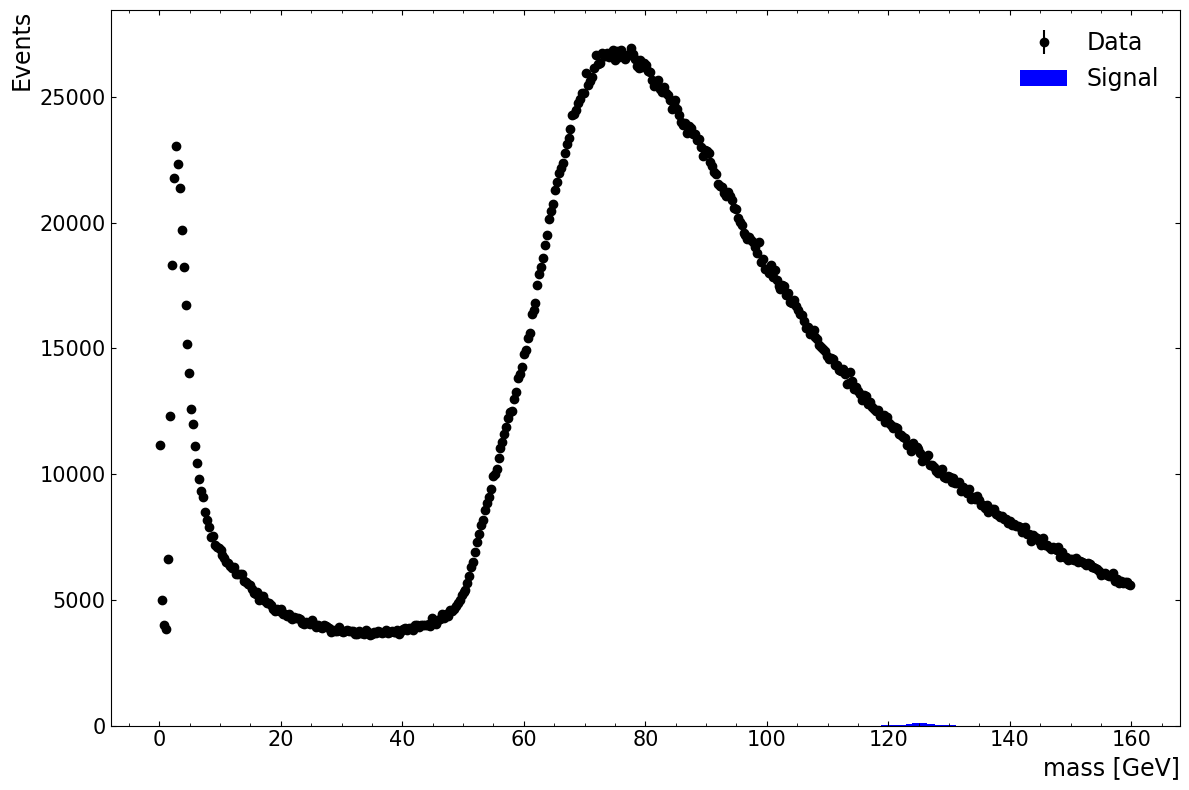

In [10]:
# Define what to plot: 'GamGam' as data, 'Hyy' as signal
plot_dict = {
    'Data' : data['GamGam_0_2'],
    'Signal' : data['Hyy_0_2']
}

# Variable to plot on the x-axis
plot_variable = 'mass'

# Define plot appearance
color_list = ['k', 'b'] # Black (data), blue (signal)
xmin, xmax = 0, 160 # Define histogram bin range and x-axis limits 
num_bins = 500 # Number of histogram bins
x_label = 'mass [GeV]' # x-axis label 

# Plot the histogram
fig, hists = plot_stacked_hist(plot_dict, plot_variable, color_list,
                               num_bins, xmin, xmax, x_label)

The `plot_stacked_hist` function accepts several optional parameters that allow you to customise the appearance and behaviour of the plot:
- `y_label` : Label for the y-axis
- `logy` : Set to `True` to use a logarithmic y-axis
- `title` : Title of the plot
- `marker` : Marker style for the data points
- `fig_size` : Tuple of two numbers for the figure size (default: `(12, 8)`)
- `show_text` : Set to `True` to display text annotations (histogram information) on the plot
- `show_back_unc` : Set to `False` to hide background uncertainty
- `fig_name` : String filename to save the plot as an image
- `residual_plot` : Set to `True` to add a residual plot (Data / MC) below the main plot
- `title_fontsize` : Font size for the plot title (default: 17)
- `label_fontsize` : Font size for the x and y axis labels (default: 17)
- `legend_fontsize` : Font size for the legend (default: 17)
- `tick_labelsize` : Font size for the axis tick labels  (default: 15)
- `text_fontsize` : Font size for text annotations (default: 14)

The function returns a `Figure` object and a list of `Hist` objects corresponding to each dataset. These `Hist` objects can be used to inspect the histogram contents in detail — the bin values, variances (for MC datasets), and underflow/overflow bins.  
For example, try uncommenting the lines below to explore the output:

In [11]:
# Data
hists[0]                 # View the full histogram object
# hists[0].view()        # Access the bin values (excluding flow bins)       # Access the variance (MC only)
# hists[0].view(flow=True)[0]  # Underflow bin value
# hists[0].view(flow=True)[-1]  # Overflow bin value

# MC 
# hists[1]                         # View the full histogram object
# hists[1].view().value           # Access the bin values (excluding flow bins)
# hists[1].view().variance        # Access the variance (MC only)
# hists[1].view(flow=True)[0].value   # Underflow bin value
# hists[1].view(flow=True)[-1].value  # Overflow bin value

Hist(Regular(500, 0, 160, name='Data'), storage=Double()) # Sum: 6074371.0 (7255271.0 with flow)

## Fitting
The `get_histogram` function returns the histogram values, associated variances, and bin centres. The histogram values of the data can be used to fit to a model — typically a polynomial model for the 'background' and a Gaussian for the Higgs mass peak.

In [13]:
# Set histogram parameters
num_bins = 200 
xmin, xmax = 110, 160

# Extract mass data from GamGam events
data_mass = data['GamGam_0_2']['mass']
data_hist_name = 'data mass'

# Get histogram values and bin centres - in this case, the variance is not needed
data_x, _, bin_centres = get_histogram(data_mass, num_bins,
                                       xmin, xmax, data_hist_name)
data_x_err = np.sqrt(data_x) # Statistical uncertainties (Poisson)

In [14]:
# Define model components
polynomial_model = PolynomialModel(4) # 4th order polynomial
gaussian_model = GaussianModel() # Gaussian

# Set initial guesses for polynomial parameters:
# c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
parameters = polynomial_model.guess(
    data_x, # data to use to guess parameter values
    x=bin_centres, c0=max(data_x), c1=0, c2=0, c3=0, c4=0
)

# Set initial guesses for Gaussian peak
parameters += gaussian_model.guess(
    data_x, # data to use to guess parameter values
    x=bin_centres, amplitude=100, center=125, sigma=2
)

# Combine the models
model = polynomial_model + gaussian_model

# Fit the model to the data
out = model.fit(data_x, # data to be fit
                parameters, # guesses for the parameters
                x=bin_centres, weights=1/data_x_err) #ASK

# Extract background parameters from the fit result
params_dict = out.params.valuesdict()
c0 = params_dict['c0']
c1 = params_dict['c1']
c2 = params_dict['c2']
c3 = params_dict['c3']
c4 = params_dict['c4']

# Get the background-only part of the fit to data
background = (c0 + c1*bin_centres + c2*bin_centres**2 +
              c3*bin_centres**3 + c4*bin_centres**4)

# Extract the full best-fit curve (background + signal)
fit = out.best_fit

/home/jovyan/.local/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


The resulting best-fit curve can be overlaid on the plot by passing it to the `plot_stacked_hist` function via the `fit` argument.  
You can customise how the fit is displayed using the optional parameters:
- `fit_fmt` : linestyle and color for the fit (default is `'-r'` for a red solid line)
- `fit_label` : legend label for the fit (default is `'fit'`)

Elapsed time = 0.2s


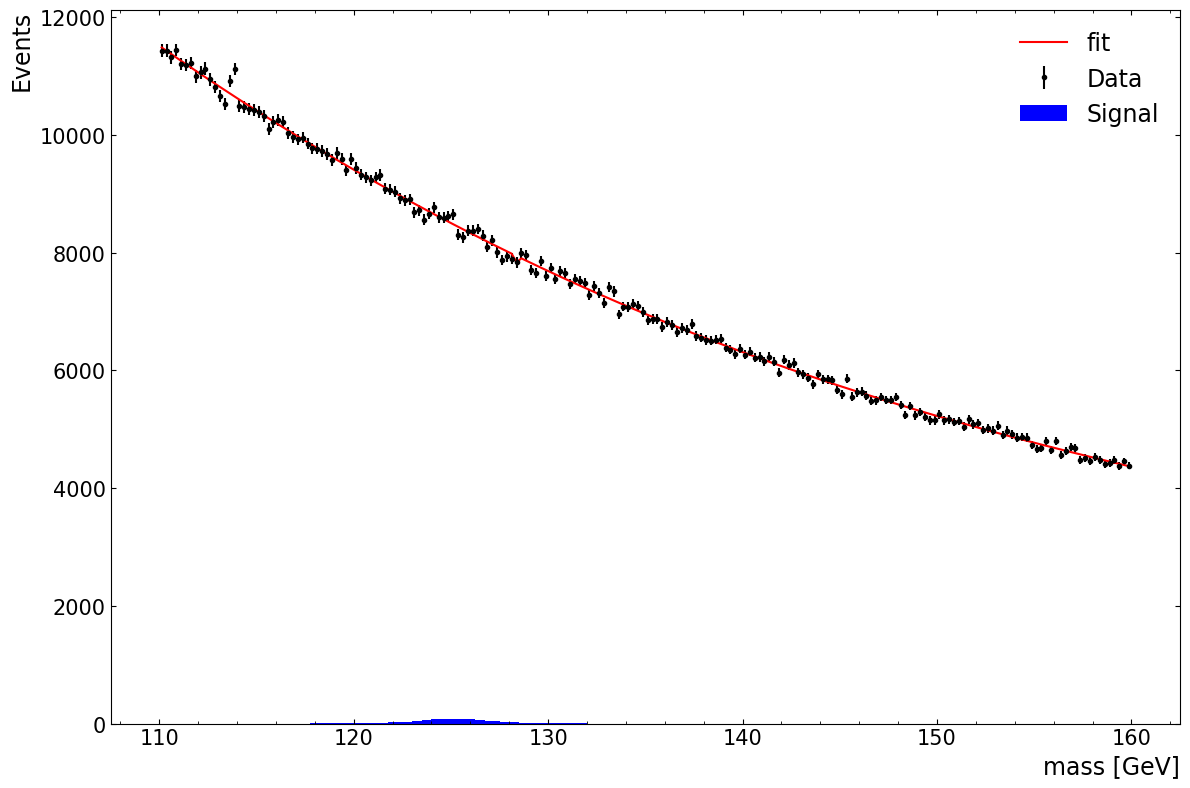

In [15]:
# Use the same num_bins, xmin, xmax as the ones used to find the fit
fig, hist = plot_stacked_hist(
    plot_dict, plot_variable, color_list,
    num_bins, xmin, xmax, x_label,
    fit=fit, marker='.')

If you take a closer look, you'll notice a *dip* in the mass distribution rather than a peak! This suggests that the current selection cuts may not be sufficient to suppress background, or that more data is needed.  
Perhaps you may want to plot additional variables to identify where the selection cut could be tightened. You can use the `plot_histograms` function, as shown in the example below.  
Note that this function returns:
- A list of `Figure` objects (one per variable plotted)
- A corresponding list of lists of `Hist` objects

Elapsed time = 0.6s


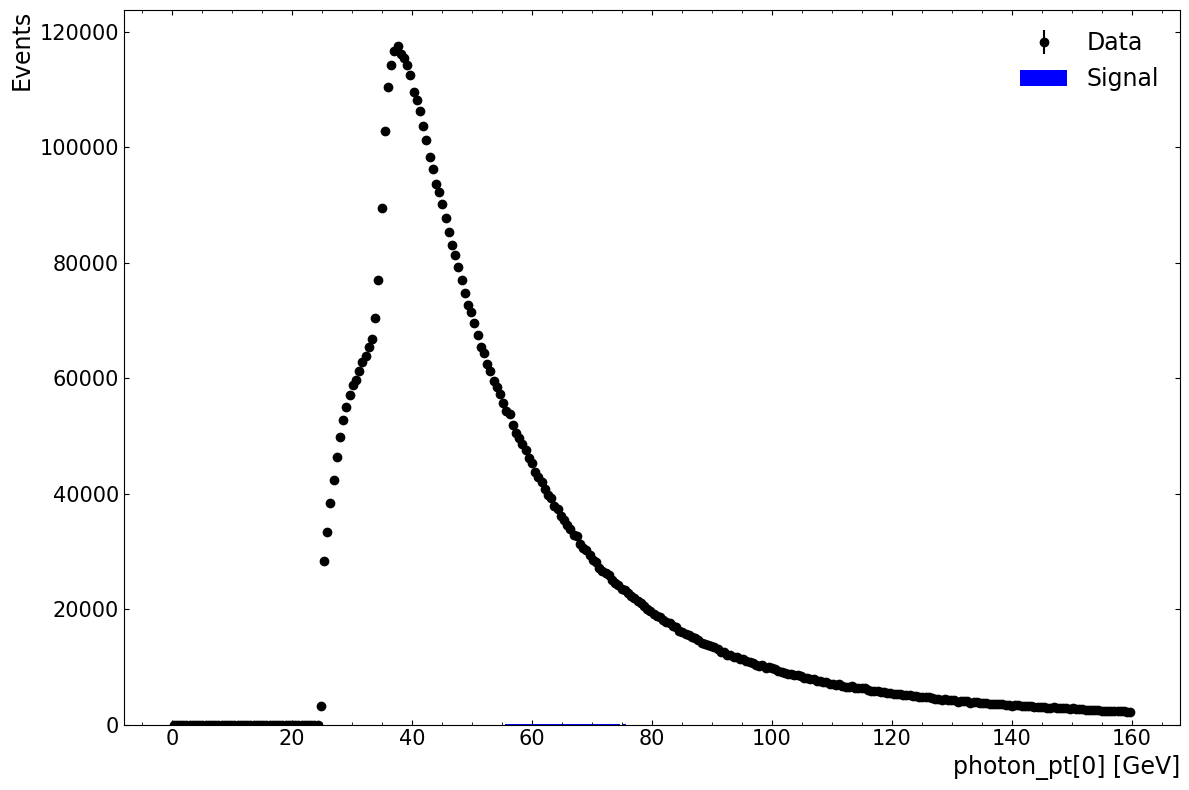

Elapsed time = 1.6s


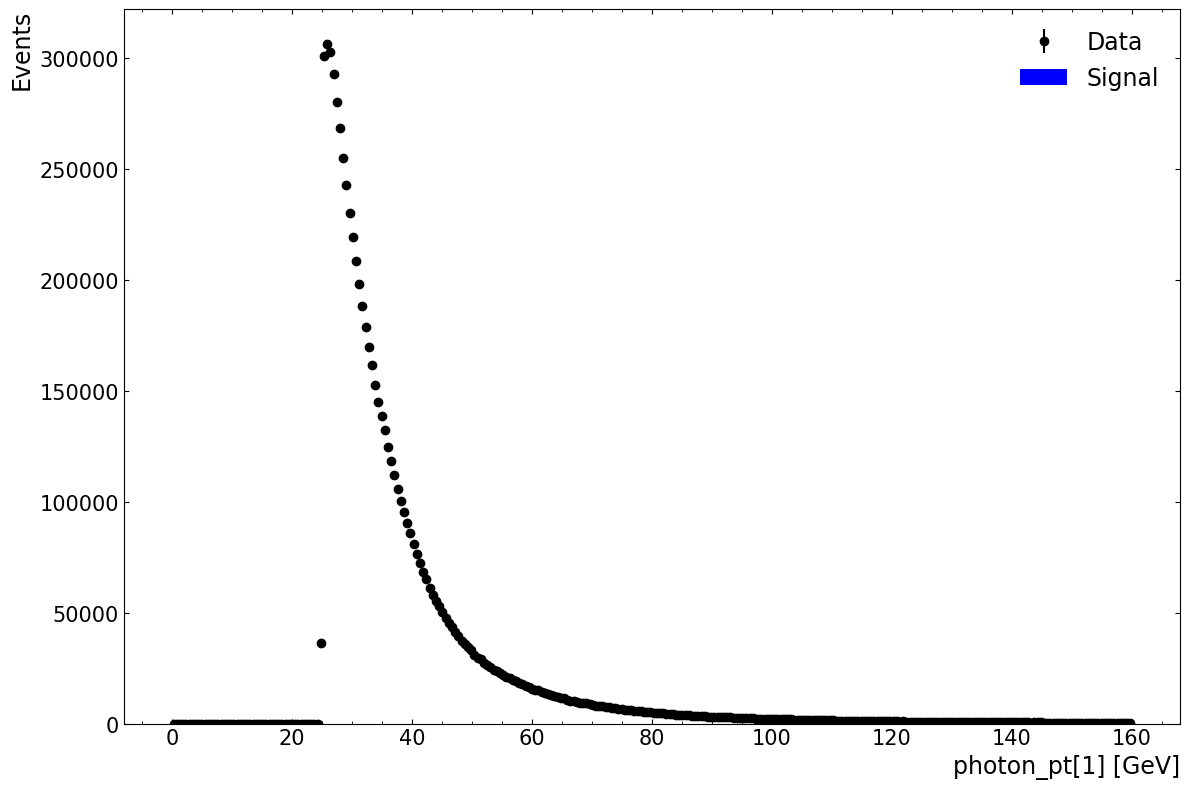

Elapsed time = 2.8s


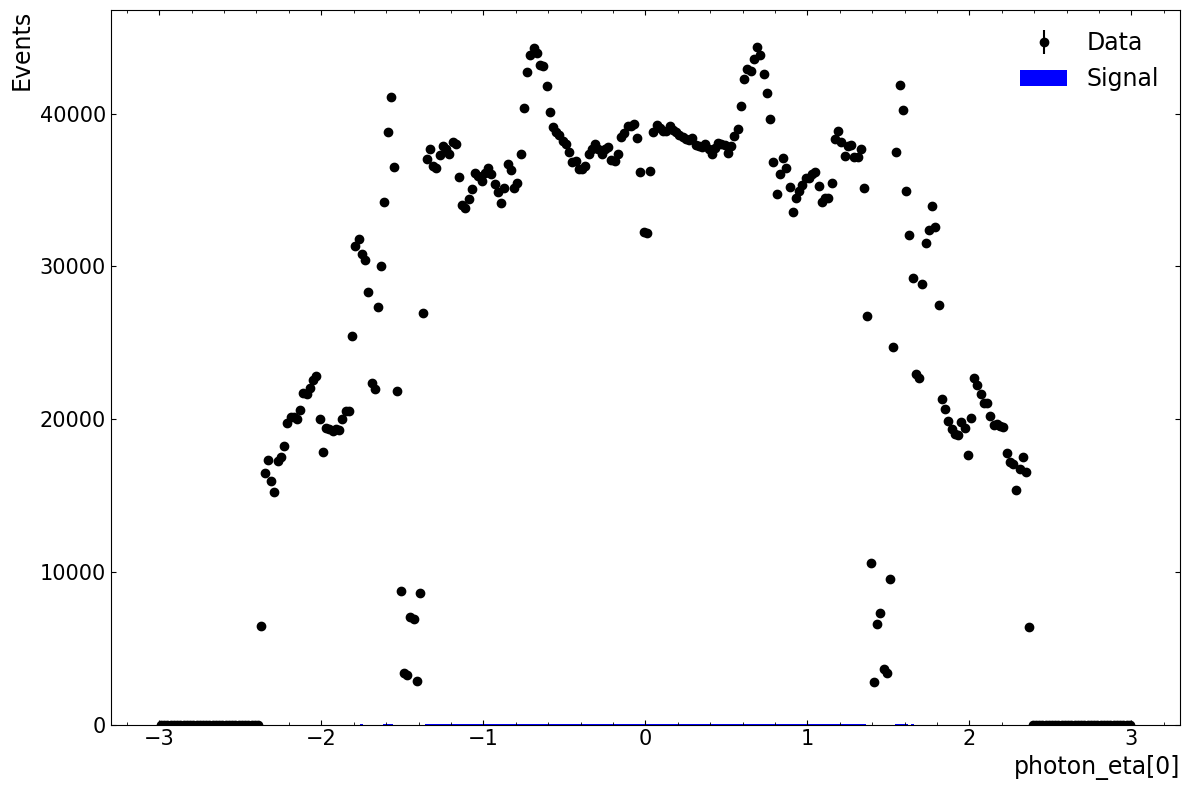

Elapsed time = 3.7s


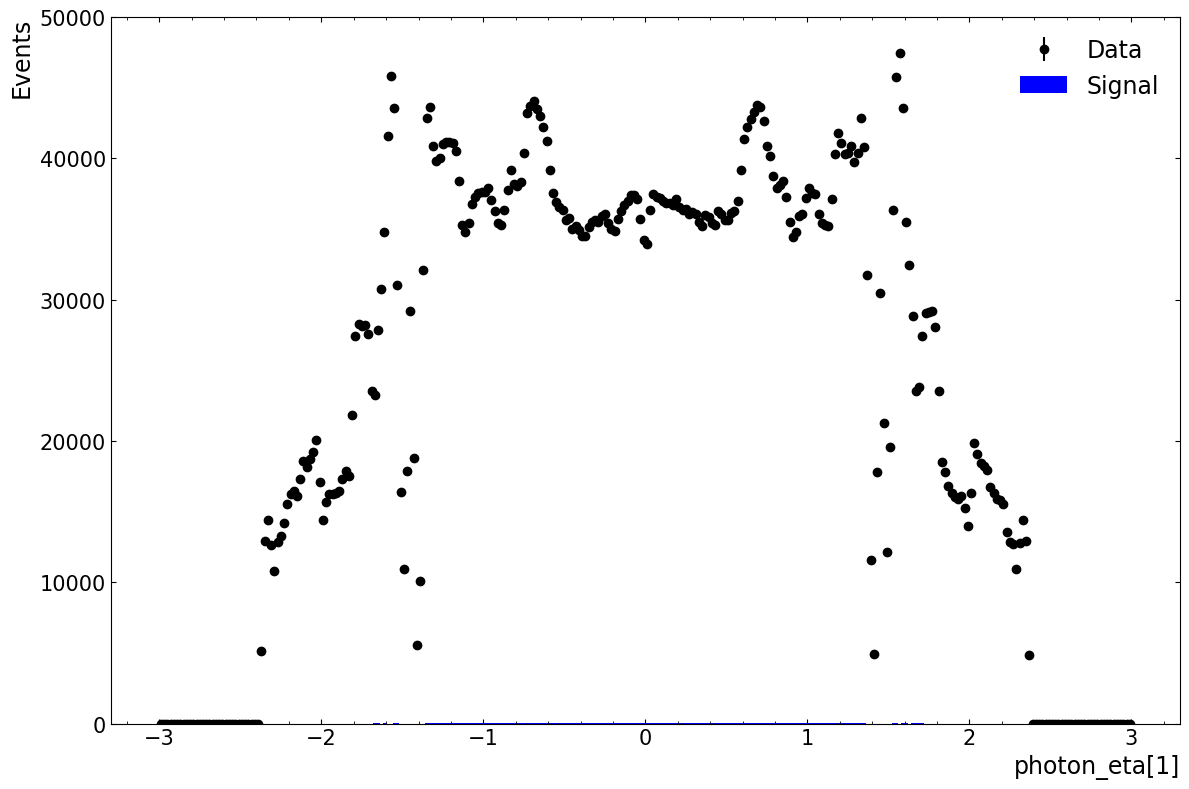

([<Figure size 1200x800 with 1 Axes>,
  <Figure size 1200x800 with 1 Axes>,
  <Figure size 1200x800 with 1 Axes>,
  <Figure size 1200x800 with 1 Axes>],
 [[Hist(Regular(300, 0, 160, name='Data'), storage=Double()) # Sum: 7042429.0 (7255271.0 with flow),
   Hist(Regular(300, 0, 160, name='Signal'), storage=Weight()) # Sum: WeightedSum(value=1596.09, variance=33.9603) (WeightedSum(value=1629.01, variance=34.6572) with flow)],
  [Hist(Regular(300, 0, 160, name='Data'), storage=Double()) # Sum: 7226728.0 (7255271.0 with flow),
   Hist(Regular(300, 0, 160, name='Signal'), storage=Weight()) # Sum: WeightedSum(value=1627.48, variance=34.6247) (WeightedSum(value=1629.01, variance=34.6572) with flow)],
  [Hist(Regular(300, -3, 3, name='Data'), storage=Double()) # Sum: 7255271.0,
   Hist(Regular(300, -3, 3, name='Signal'), storage=Weight()) # Sum: WeightedSum(value=1629.01, variance=34.6572)],
  [Hist(Regular(300, -3, 3, name='Data'), storage=Double()) # Sum: 7255271.0,
   Hist(Regular(300, -3, 

In [16]:
# Plot many variables at once 
plot_variables = ['photon_pt[0]', 'photon_pt[1]', 'photon_eta[0]', 'photon_eta[1]']
xmin_xmax_list = [(0, 160), (0, 160), (-3, 3), (-3, 3)] # Bin range for each variable
color_list = ['k', 'b'] # Black (data) and blue (MC)
num_bins_list = 300 # If you give an int instead of a list, this number of bins will be applied to all variables
x_label_list = ['photon_pt[0] [GeV]', 'photon_pt[1] [GeV]', 'photon_eta[0]', 'photon_eta[1]']

plot_histograms(
    plot_dict,
    plot_variables,
    color_list,
    xmin_xmax_list,
    num_bins_list,
    x_label_list
    # Optional arguments start from here
    # y_label_list=None, # Str or list of str for y-axis label
    # logy=False, # Whether to set the y axis as log scale
    # title_list=None, # Str or list of str for title
    # marker='o', # Marker type
    # title_fontsize=17, # Fontsize for title
    # label_fontsize=17, # Fontsize for x and y axes
    # legend_fontsize=17, # Fontsize for legend
    # tick_labelsize=15, # Fontsize for x and y axes ticks
    # text_fontsize=14, # Fontsize for text that shows histogram info
    # fig_size=(12, 8), # Figure size
    # show_text=False, # Whether to show the text that displays histogram info
    # show_back_unc=True, # Whether to show the background uncertainty
    # residual_plot=False # Whether to show residual plot under the main plot
    )
               
               

## Write the Data to Disk
When working with larger datasets, e.g. using a higher `fraction` in `analysis_pq`, it is often more efficient to write the data to disk rather than keeping it all in memory. 

To do this, set the optional argument `write_parquet=True`. This will instruct the `analysis_pq` function to save the output as Parquet files. If you write data to disk, it is recommended to set `return_output=False` to avoid loading large amounts of data into memory.  

In addition, you can customise the output location using the `output_directory` argument. If not provided, the files will be saved in an `output` folder with a unique name created from the current date and time.  

Note: The provided output directory must be unique and cannot be reused. Attempting to write to an existing directory will raise a FileExistsError to prevent accidental overwriting of data.   

In [17]:
read_variables = get_valid_variables('GamGam') # Save all available variables
output_dir = 'output/test'

analysis_pq(string_code_list, read_variables, fraction=1,
            cut_function=yy_cut, write_parquet=True,
            output_directory=output_dir, return_output=False)

Elapsed time = 52.2s


The files saved by `analysis_pq` can be loaded using the `read_parquet` function. Similar to `analysis_pq`, you can define a cut function and pass it to `read_parquet`. You can also write the data back to Parquet files by setting `write_parquet=True` and customise the output location. The newly written files can then be loaded using the same function.  

Before loading large datasets, it is recommended to restart the kernel to free up memory. Avoid reading too many variables at once to reduce memory usage.

In [18]:
read_directory = 'output/test' # Directory where data is saved
subdirectory_names = ['GamGam_1', 'Hyy_1'] # Subdirectories to read from
read_variables = ['mass'] # Variables to read
read_parquet(read_directory, subdirectory_names, read_variables,
             cut_function=None, write_parquet=True,
             output_directory=None, return_output=False)

Created output_directory: output/read_parquet202508041355
Elapsed time = 4.5s


## 2D Histogram
If you want to plot a 2D histogram, you can use the `histogram_2d` function as shown in the code cell below.

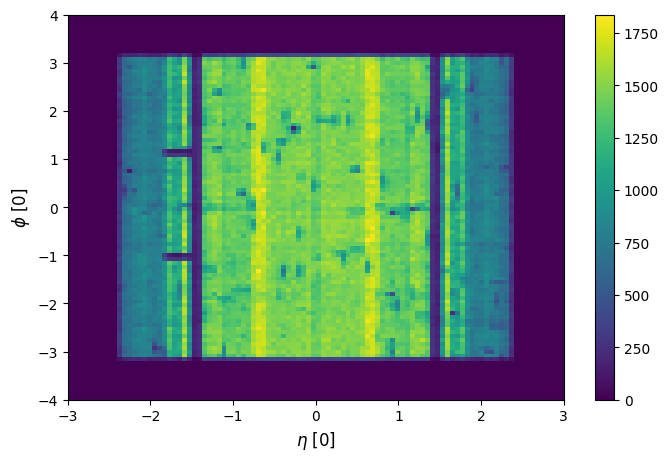

(<Figure size 800x500 with 2 Axes>,
 Hist(
   Regular(100, -3, 3, underflow=False, overflow=False, name='$\\eta$ [0]'),
   Regular(100, -4, 4, underflow=False, overflow=False, name='$\\phi$ [0]'),
   storage=Double()) # Sum: 7255271.0)

In [19]:
# eta and phi of the first photon (index 0) in each event
data_eta0 = data['GamGam_0_2']['photon_eta'][:, 0]
data_phi0 = data['GamGam_0_2']['photon_phi'][:, 0]

data_2d = (data_eta0, data_phi0) # Plot eta on x-axis, phi on y-axis
num_bins_2d = (100, 100) # Number of bins along x and y-axis 
min_max_2d = ((-3, 3), (-4, 4)) # The bin range in x and y
label_2d = ('$\\eta$ [0]', '$\\phi$ [0]') # The labels for x and y-axis

# Plot the 2D histogram
histogram_2d(data_2d, num_bins_2d,
             min_max_2d, label_2d,
             # Optional arguments
             # label_fontsize=12, tick_labelsize=10,
             # title_fontsize=13, title='',
             # colorbar_label='Events'
            )